# Классификация: превышает ли значение CC50 медианное значение выборки

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    cross_val_score,
    cross_validate
)
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    make_scorer
)
import optuna

In [3]:
df_clean = pd.read_csv("df_cleaned.csv")
df_clean.head(5)

,Unnamed: 0,"IC50, mM","CC50, mM",SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,0,6.239374,175.482382,28.125000,5.094096,5.094096,0.387225,0.387225,0.417362,42.928571,...,0,0,0,0,0,0,0,0,3,0
1,1,0.771831,5.402819,7.000000,3.961417,3.961417,0.533868,0.533868,0.462473,45.214286,...,0,0,0,0,0,0,0,0,3,0
2,2,223.808778,161.142320,0.720000,2.627117,2.627117,0.543231,0.543231,0.260923,42.187500,...,2,0,0,0,0,0,0,0,3,0
3,3,1.705624,107.855654,63.235294,5.097360,5.097360,0.390603,0.390603,0.377846,41.862069,...,0,0,0,0,0,0,0,0,4,0
4,4,107.131532,139.270991,1.300000,5.150510,5.150510,0.270476,0.270476,0.429038,36.514286,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Смотрим размер дата сета
df_clean.shape

(980, 196)

In [5]:
CC50_COL  = "CC50, mM"
TARGET_COL = "CC50_median"

# Находим медиану
cc50_median = df_clean[CC50_COL].median()
print(f"CC50 median (mM): {cc50_median:.4g}")

# Бинарная целевая переменная: 1, если CC50 > медианы, иначе 0
df_clean[TARGET_COL] = (df_clean[CC50_COL] > cc50_median).astype(int)

CC50 median (mM): 405.6


In [6]:
# Удаляем целевые переменные и не информативный признак 
X = df_clean.drop(['IC50, mM', 'SI', 'CC50, mM', 'Unnamed: 0', TARGET_COL], axis=1)
y = df_clean[TARGET_COL]

In [7]:
# автоматически отбираем признаки с важностью выше медианы, чтобы сократить размерность данных.
rf = RandomForestClassifier(n_estimators=80, random_state=42)
selector = SelectFromModel(rf, threshold="median")  
X_selected = selector.fit_transform(X, y)
X_selected.shape

(980, 96)

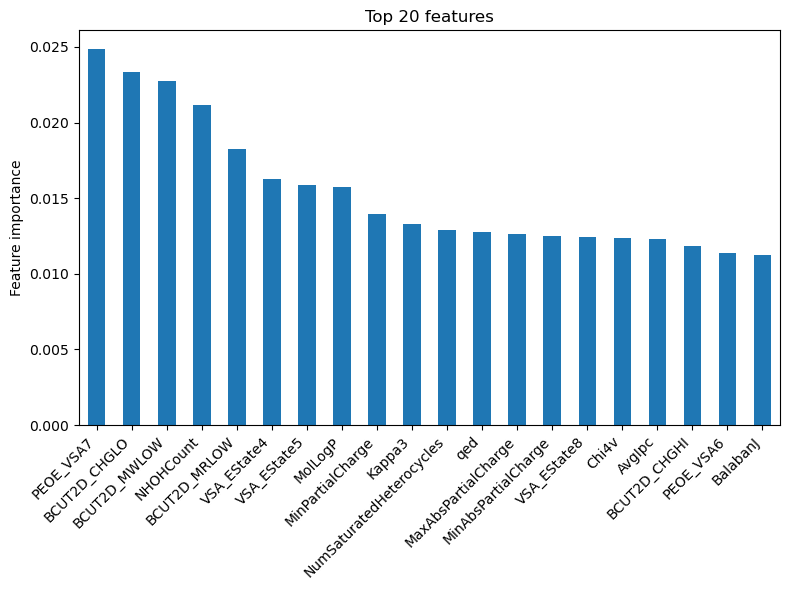

In [8]:
# названия и важности только для выбранных фич
mask            = selector.get_support()
selected_names  = X.columns[mask]
importances_sel = selector.estimator_.feature_importances_[mask]

# отсортируем и возьмём топ-20
feat_imp = (
    pd.Series(importances_sel, index=selected_names)
      .sort_values(ascending=False)
      .head(20)
)

# рисуем
plt.figure(figsize=(8, 6))
feat_imp.plot(kind="bar")
plt.ylabel("Feature importance")
plt.title("Top 20 features")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

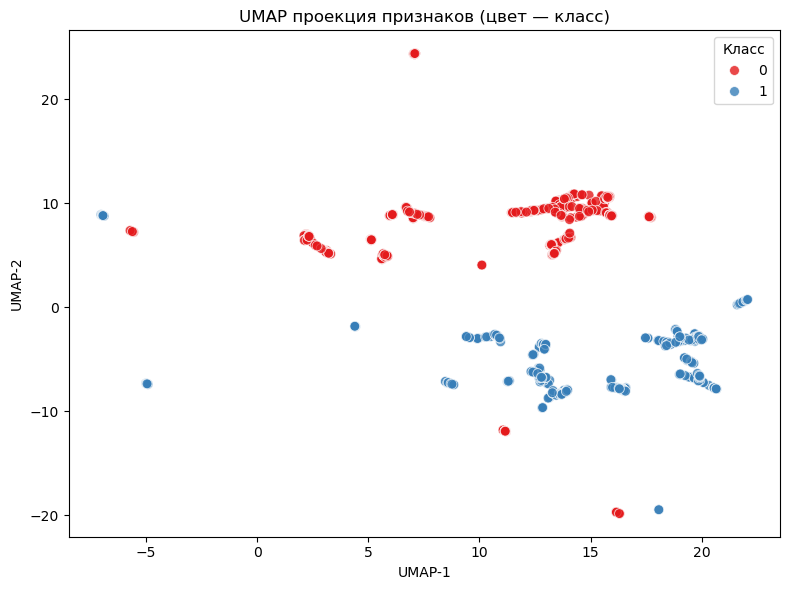

In [9]:
# Масштабирование
X_scaled = StandardScaler().fit_transform(X_selected)

# UMAP проекция в 2D
reducer = umap.UMAP(n_neighbors=30, min_dist=0.05, metric="cosine")
X_umap = reducer.fit_transform(X_scaled, y)

# Визуализация
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y, palette="Set1", s=50, alpha=0.8)
plt.title("UMAP проекция признаков (цвет — класс)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend(title="Класс")
plt.tight_layout()
plt.show()

In [10]:
# разделим данные на тренировачную и тестовую подвыбарку 
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

In [11]:
# Выводим распределение классов в обучающей выборке (в процентах)
class_dist = y_train.value_counts(normalize=True) * 100
print(f"\nРаспределение классов в обучающей выборке:\n"
      f"  CC50 > медианы: {class_dist[0]:.2f}%\n"
      f"  CC50 < медианы: {class_dist[1]:.2f}%")


Распределение классов в обучающей выборке:
  CC50 > медианы: 49.49%
  CC50 < медианы: 50.51%


In [12]:
# Список моделей для обучения
base_models_cls = {
    "RandomForest":  RandomForestClassifier(random_state=42, n_jobs=-1),
    "ExtraTrees":    ExtraTreesClassifier(random_state=42, n_jobs=-1),
    "HistGBC":       HistGradientBoostingClassifier(random_state=42),
    "XGBoost":       XGBClassifier(random_state=42),
    "LightGBM":      LGBMClassifier(verbosity=-1, random_state=42),
    "CatBoost":      CatBoostClassifier(random_state=42, verbose=0),
}

# Оборачиваем каждую модель в Pipeline (scaler + модель)
models = {
    name: Pipeline([
        ("scaler", StandardScaler()),
        ("model", mdl)
    ])
    for name, mdl in base_models_cls.items()
}

# Кросс-валидация и метрики
CV = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
SCORERS = {
    "accuracy":  "accuracy",
    "precision": "precision",
    "recall":    "recall",
    "f1":        "f1",
    "roc_auc":   "roc_auc"
}

results = {}

for name, pipe in models.items():
    print(f"Обучение {name}...")
    cv_res = cross_validate(
        pipe,
        X_train,           # уже готовый train-split
        y_train,
        cv=CV,
        scoring=SCORERS,
        n_jobs=-1,
        return_estimator=False
    )
    # усредняем метрики
    results[name] = {m: (cv_res[f'test_{m}'].mean(), cv_res[f'test_{m}'].std())
                     for m in SCORERS.keys()}
    print("  " + " | ".join(
        f"{m}: {mean:.3f}±{std:.3f}" for m, (mean, std) in results[name].items()
    ))

Обучение RandomForest...
  accuracy: 0.753±0.033 | precision: 0.749±0.026 | recall: 0.768±0.063 | f1: 0.757±0.038 | roc_auc: 0.837±0.018
Обучение ExtraTrees...
  accuracy: 0.758±0.021 | precision: 0.766±0.028 | recall: 0.753±0.040 | f1: 0.758±0.022 | roc_auc: 0.826±0.025
Обучение HistGBC...
  accuracy: 0.742±0.030 | precision: 0.742±0.028 | recall: 0.750±0.037 | f1: 0.746±0.031 | roc_auc: 0.836±0.023
Обучение XGBoost...
  accuracy: 0.746±0.025 | precision: 0.742±0.012 | recall: 0.763±0.056 | f1: 0.751±0.033 | roc_auc: 0.831±0.024
Обучение LightGBM...
  accuracy: 0.759±0.027 | precision: 0.763±0.025 | recall: 0.758±0.050 | f1: 0.760±0.032 | roc_auc: 0.833±0.018
Обучение CatBoost...
  accuracy: 0.758±0.017 | precision: 0.751±0.020 | recall: 0.780±0.053 | f1: 0.764±0.023 | roc_auc: 0.842±0.018


In [13]:
# Итоговая таблица mean ± std
summary = pd.DataFrame({
    (metric, stat): {
        model: results[model][metric][0] if stat == "mean" else results[model][metric][1]
        for model in results
    }
    for metric in SCORERS.keys()
    for stat in ["mean", "std"]
}).sort_values(("f1", "mean"), ascending=False)

print("\nСравнение моделей (CV, mean ± std):")
display(summary)


Сравнение моделей (CV, mean ± std):


accuracy           precision              recall            \
                  mean       std      mean       std      mean       std   
CatBoost      0.757676  0.017255  0.751124  0.019890  0.780348  0.052645   
LightGBM      0.758966  0.026843  0.763426  0.024575  0.757627  0.049967   
ExtraTrees    0.757684  0.020599  0.765630  0.028172  0.752563  0.040236   
RandomForest  0.752597  0.032774  0.748870  0.025645  0.767816  0.062686   
XGBoost       0.746203  0.025332  0.741563  0.012376  0.762722  0.055783   
HistGBC       0.742381  0.030039  0.742357  0.027889  0.750032  0.036785   

                    f1             roc_auc            
                  mean       std      mean       std  
CatBoost      0.764158  0.023291  0.841996  0.017776  
LightGBM      0.759789  0.032219  0.832883  0.018384  
ExtraTrees    0.758021  0.021970  0.825980  0.024782  
RandomForest  0.757176  0.037848  0.836517  0.017798  
XGBoost       0.751256  0.032636  0.830542  0.024212  
HistGBC       0.746068  0.031418  0.836296  0.023207

In [14]:
# Список результатов метрик
test_results = {}

# Предсказания и метрики
all_conf_matrices = {}

for name, pipe in models.items():    
    # Обучение
    pipe.fit(X_train, y_train)
    
    # Предсказания
    y_pred = pipe.predict(X_test)
    y_proba = pipe.predict_proba(X_test)[:, 1] if hasattr(pipe.named_steps['model'], "predict_proba") else None

    # Метрики
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    roc  = roc_auc_score(y_test, y_proba) if y_proba is not None else float('nan')

    test_results[name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1,
        "roc_auc": roc
    }
    # Сохраняем confusion matrix для последующего вывода
    all_conf_matrices[name] = confusion_matrix(y_test, y_pred)

In [15]:
# Таблица метрик на тестовой выборке
test_summary_df = pd.DataFrame(test_results).T
test_summary_df = test_summary_df.round(3)  

print("\n Сводная таблица метрик на тестовой выборке:")
display(test_summary_df.sort_values("f1", ascending=False))


 Сводная таблица метрик на тестовой выборке:


,accuracy,precision,recall,f1,roc_auc
HistGBC,0.796,0.760,0.840,0.798,0.860
LightGBM,0.791,0.752,0.840,0.794,0.860
CatBoost,0.786,0.736,0.862,0.794,0.874
XGBoost,0.781,0.743,0.830,0.784,0.858
ExtraTrees,0.765,0.726,0.819,0.770,0.841
RandomForest,0.760,0.724,0.809,0.764,0.852



 Confusion matrices:


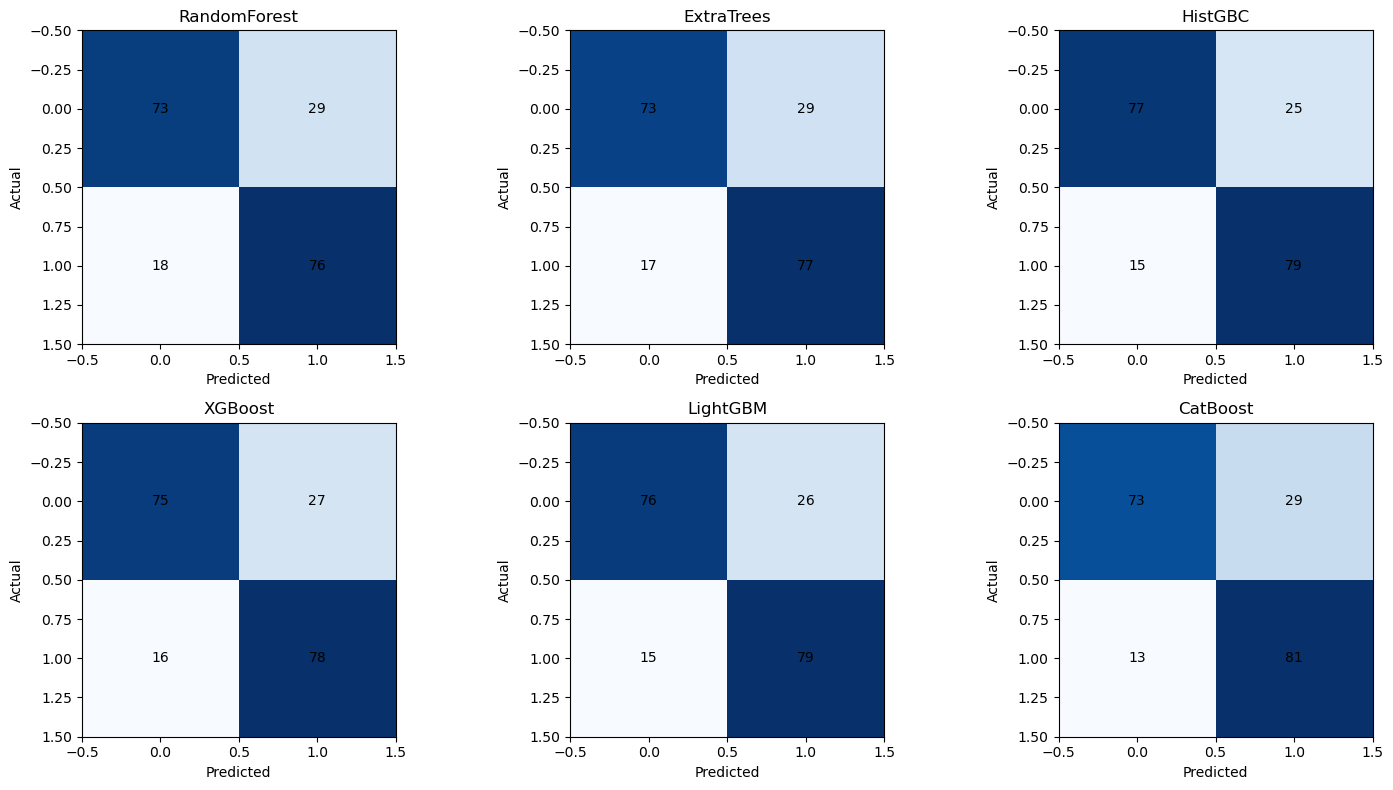

In [16]:
# Визуализация confusion matrix
print("\n Confusion matrices:")

n_models = len(all_conf_matrices)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

for idx, (name, cm) in enumerate(all_conf_matrices.items()):
    ax = axes[idx]
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, cm[i, j], ha="center", va="center", color="black")

# Удаляем лишние оси
for i in range(len(all_conf_matrices), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [17]:
# CV-стратегия и скорер
CV     = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
SCORER = make_scorer(f1_score, zero_division=0)

# функция генерации параметров
def suggest_rf_params(trial):
    return {
        "n_estimators"     : trial.suggest_int("n_estimators", 100, 800, step=100),
        "max_depth"        : trial.suggest_categorical("max_depth", [None, *range(3, 31)]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 20),
        "min_samples_leaf" : trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features"     : trial.suggest_categorical("max_features", ["sqrt", "log2", 0.5, None]),
        "bootstrap"        : trial.suggest_categorical("bootstrap", [True, False]),
        "class_weight"     : trial.suggest_categorical("class_weight", [None, "balanced", "balanced_subsample"]),
        "random_state"     : 42,
        "n_jobs"           : -1,
    }

def objective(trial):
    model  = RandomForestClassifier(**suggest_rf_params(trial))
    score  = cross_val_score(model, X_train, y_train,
                             cv=CV, scoring=SCORER, n_jobs=-1).mean()
    return score

# запуск оптимизации
study = optuna.create_study(direction="maximize", study_name="RF_F1")
study.optimize(objective, n_trials=50, timeout=600, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)
print("Лучшая F1 (CV):", round(study.best_value, 4))

# финальная модель
best_rf = RandomForestClassifier(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

[I 2025-06-15 17:05:10,922] A new study created in memory with name: RF_F1


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2025-06-15 17:05:12,481] Trial 0 finished with value: 0.7414505545362887 and parameters: {'n_estimators': 700, 'max_depth': 6, 'min_samples_split': 17, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7414505545362887.
[I 2025-06-15 17:05:13,552] Trial 1 finished with value: 0.7534710192242774 and parameters: {'n_estimators': 400, 'max_depth': 17, 'min_samples_split': 17, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7534710192242774.
[I 2025-06-15 17:05:15,303] Trial 2 finished with value: 0.7500151342189013 and parameters: {'n_estimators': 600, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: 0.7534710192242774.
[I 2025-06-15 17:05:19,130] Trial 3 finished with value: 0.7403902699812884 and pa

RandomForestClassifier(bootstrap=False, max_depth=23, min_samples_split=14,
                       n_estimators=800, n_jobs=-1, random_state=42)

Метрики на тестовой выборке:


,Accuracy,Precision,Recall,F1-score,ROC AUC
0,0.765,0.722,0.83,0.772,0.87


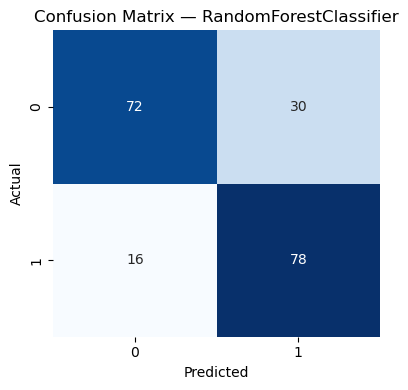

In [18]:
# Предсказания
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

# Метрики
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
roc  = roc_auc_score(y_test, y_proba)

# Таблица метрик
metrics_df = pd.DataFrame({
    "Accuracy": [acc],
    "Precision": [prec],
    "Recall": [rec],
    "F1-score": [f1],
    "ROC AUC": [roc]
}).round(3)

print("Метрики на тестовой выборке:")
display(metrics_df)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix — RandomForestClassifier")
plt.tight_layout()
plt.show()